# Bibliotecas

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import json

# Base de dados

In [7]:
df = pd.read_excel('Base120.xlsx')

In [8]:
def filtra_por_solucao(df, vet_solucao):
    '''Recebe um vetor solução e retorna o df filtrado para essa solução'''
    stand_prescription_map = {i + 1: vet_solucao[i] for i in range(len(vet_solucao))}
    filtered_df = df[df.apply(lambda row: row['prescrição'] == stand_prescription_map.get(row['talhao']), axis=1)]
    return filtered_df

def calcula_volume(result):
	"""
	Calculate the volume by summing specific columns of a DataFrame.
	This function takes a DataFrame `result` and returns the sum of the values
	in columns 3 to 18 (inclusive).
	Parameters:
	result (pandas.DataFrame): The input DataFrame containing the data.
	Returns:
	pandas.Series: A Series containing the sum of the specified columns.
	"""
	
    
	return result.iloc[:, 3:19].sum()

def calcula_penalidade(volume_anual):
    '''retorna penalidade por volume excedente/faltante (R$500)'''
    upper = []
    lower = []
    for v_ano in volume_anual:
        if v_ano < 140000:
            lower.append(np.abs(v_ano - 140000))
        elif v_ano > 160000:
            upper.append(np.abs(v_ano - 160000))
    return np.sum(upper + lower)*500

def calcula_vpl_aux(result, volume_ano):
    '''Calcula o VPL penalizado (função auxiliar)'''
    return np.sum(result['VPL']) - calcula_penalidade(volume_ano)

def plota_volume(df, vet_sol):
    '''Plota o gráfico do volume nos anos'''
    volume_ano = filtra_por_solucao(df, vet_sol).iloc[:, 3:19].sum()
    (volume_ano/1000).plot(kind='bar')
    plt.hlines(140, xmin=-1, xmax=16, color='red', alpha=.6)
    plt.hlines(160, xmin=-1, xmax=16, color='red', alpha=.6)
    plt.title("Volume de madeira por ano")
    plt.xlabel("Ano de Produção")
    plt.ylabel("Volume (1000 m$^3$)")

def calcula_volume_aux(df, vet_sol):
	"""
	Calculate the auxiliary volume based on the given solution vector.
	This function filters the DataFrame `df` using the solution vector `vet_sol`
	and then sums the values in columns 3 to 18 (inclusive) of the filtered DataFrame.
	Parameters:
	df (pandas.DataFrame): The input DataFrame containing the data.
	vet_sol (list or array-like): The solution vector used to filter the DataFrame.
	Returns:
	pandas.Series: A Series containing the sum of the values in columns 3 to 18 of the filtered DataFrame.
	"""
    
	return filtra_por_solucao(df, vet_sol).iloc[:, 3:19].sum()

def calcula_vpl_total(df, vet_solucao):
    '''Calcula o VPL total penalizado'''
    result = filtra_por_solucao(df, vet_solucao)
    volume_ano = calcula_volume(result)
    return calcula_vpl_aux(result, volume_ano)

def encontra_pior_ano(df, sol):
    volume_ano = calcula_volume_aux(df, sol)
    # return np.argmax(np.where(volume_ano>160000,
    #                           np.abs(volume_ano-160000),
    #                           np.abs(volume_ano-140000))) + 1
    return np.argmax(np.abs(volume_ano-160000)) + 1

---

## Alteração na base de dados

In [9]:
df_2 = df.drop_duplicates(subset=['talhao'] + df.columns[3:].tolist(), keep='first')
df_2.to_csv('base_reduzida.csv', index=False)

# Busca Local

Sorteie um dos 120 talhões e gera os vizinhos para todas suas precrições, alterando a solução atual para o melhor vizinho e repetindo o processo.

## Soluções importadas


In [10]:
with open("solucoes_alpha.json", "r") as arquivo: # soluções geradas por heurística construtiva
    solucoes_alpha = json.load(arquivo)
solucoes_alpha = [np.array(sol) for sol in solucoes_alpha]

In [ ]:
import random
import matplotlib.ticker as ticker

def gera_vizinhos(df, vet_solucao):
    """
    Gera vizinhos de um talhão sorteado
    """
    vizinhos = []
    talhao_sorteado = random.randint(0, 119)
    prescricoes_talhao = df[df['talhao'] == talhao_sorteado+1]['prescrição'].unique() # prescrições únicas de cada talhão
    for prescricao in prescricoes_talhao:
        vizinho = vet_solucao.copy()
        vizinho[talhao_sorteado] = prescricao # altera solução
        vizinhos.append(vizinho)
    return vizinhos

def gera_vizinhos_localizado(df, solucao):
    """
    Gera uma lista de vizinhos localizados para uma solução dada.
    Esta função identifica o pior ano em uma solução e, em seguida, encontra
    todos os talhões que podem ser colhidos naquele ano com base nas idades
    de colheita fornecidas.
    Args:
        df (pd.DataFrame): DataFrame contendo informações sobre os talhões,
                             incluindo a idade de cada talhão.
        solucao (list): Lista representando a solução atual.
        idade_colheita (dict): Dicionário onde as chaves são anos e os valores
                               são listas de idades possíveis para colheita
                               naquele ano.
    Returns:
        None: A função imprime o pior ano e os talhões possíveis para colheita
              naquele ano.
    """
    
    idade_colheita = {1: ['5', '6'],
                  2: ['4', '5', '6'],
				  3: ['3', '4', '5'],
				  4: ['2', '3', '4'],
				  5: ['1', '2', '3'],
				  6: ['1', '2', '5', '6'],
				  7: ['1', '4', '5', '6'],
				  8: ['3', '4', '5', '6'],
				  9: ['2', '3', '4', '5', '6'],
				  10: ['1', '2', '3', '4', '5'],
				  11: ['1', '2', '3', '4', '5', '6'],
				  12: ['1', '2', '3', '4', '5', '6'],
				  13: ['1', '2', '3', '4', '5', '6'],
				  14: ['1', '2', '3', '4', '5', '6'],
				  15: ['1', '2', '3', '4', '5', '6'],
				  16: ['1', '2', '3', '4', '5', '6']}
    pior_ano = encontra_pior_ano(df, solucao)
    possiveis_idades = idade_colheita[pior_ano]
    possiveis_talhoes = df[np.isin(df.loc[:, 'idade'], list(map(int, possiveis_idades)))]['talhao'].unique() # talhoes que podem fazer colheita naquele ano
    talhao_sorteado = random.sample(list(possiveis_talhoes), 1)
    vizinhos = []
    prescricoes_talhao = df[df['talhao'] == talhao_sorteado[0]]['prescrição'].unique() # prescrições únicas de cada talhão
    
    for prescricao in prescricoes_talhao:
        vizinho = solucao.copy()
        vizinho[talhao_sorteado[0]-1] = prescricao # altera solução
        vizinhos.append(vizinho)
    return vizinhos

def gera_vizinhos_sistematico(df, sol):
    """
    Gera vizinhos sistemáticos para uma solução dada.
    Parâmetros:
    df (pandas.DataFrame): DataFrame contendo os dados com colunas 'talhao' e 'prescrição'.
    sol (numpy.ndarray): Array representando a solução atual.
    Retorna:
    numpy.ndarray: Array de vizinhos gerados sistematicamente.
    """
    
    # Gera 120 vizinhos com talhões alterados sistematicamente para um prescrição aleatória
    vizinhos = np.tile(sol, (120, 1))
    for pos, vizinho in enumerate(vizinhos):
        prescricoes = df[df['talhao'] == pos + 1]['prescrição'].unique()
        vizinho[pos] = random.choice(prescricoes)
        
    return vizinhos

def varre_vizinhos(vizinhos, sol_atual, df, metodo):
    """
    Returns the neighbor with the highest VPL.
    """
    max_vpl = calcula_vpl_total(df, sol_atual)  # Initialize with negative infinity to ensure the first neighbor is considered
    melhor_vizinho = sol_atual

    for vizinho in vizinhos:
        vpl_atual = calcula_vpl_total(df, vizinho)
        if metodo=='mm': # melhor melhor
            if vpl_atual > max_vpl:
                max_vpl = vpl_atual
                melhor_vizinho = vizinho
        elif metodo=='pm': # primeiro melhor
            if vpl_atual > max_vpl:
                max_vpl = vpl_atual
                melhor_vizinho = vizinho
                break

    return melhor_vizinho  # Return the neighbor with the highest VPL

def busca_local(df, sol_atual, tempo_max, seed=42, metodo='mm', vizinhanca='aleatoria'):
    inicio = time.time()
    counter_melhor_vizinho, counter_nova_solucao, counter_quant_sol = 0, 0, 0
    melhores_vpl = []
    random.seed(seed)

    while True:
        if time.time() - inicio > tempo_max:
            print("Tempo máximo atingido")
            break
        
        # gera vizinhanças diferentes
        if vizinhanca=='aleatoria':
            vizinhos_sol_atual = gera_vizinhos(df, sol_atual)
        elif vizinhanca=='localizada':
            vizinhos_sol_atual = gera_vizinhos_localizado(df, sol_atual)
        elif vizinhanca=='sistematica':
            vizinhos_sol_atual = gera_vizinhos_sistematico(df, sol_atual)
        
        melhor_vizinho = varre_vizinhos(vizinhos_sol_atual, sol_atual, df, metodo=metodo)

        if all(melhor_vizinho == sol_atual):
            counter_nova_solucao +=1
            continue
        else:
            sol_atual = melhor_vizinho
            melhores_vpl.append(calcula_vpl_total(df, sol_atual))
            counter_melhor_vizinho += 1
            counter_quant_sol += 1

    plt.plot(range(counter_quant_sol), melhores_vpl, label=metodo)
    plt.xlabel('Número de iterações')
    plt.ylabel('VPL')
    plt.title('VPL ao longo das iterações')
    plt.grid(True)
    plt.legend()
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

    print(counter_melhor_vizinho, ' trocas para melhor vizinho')
    print(counter_nova_solucao, ' trocas para nova solução')
    return (calcula_vpl_total(df, sol_atual), sol_atual)

In [12]:
calcula_vpl_total(df_2, solucoes_alpha[2])

np.int64(-54932408)

Tempo máximo atingido
13  trocas para melhor vizinho
4  trocas para nova solução
Melhor melhor
VPL:  17941172


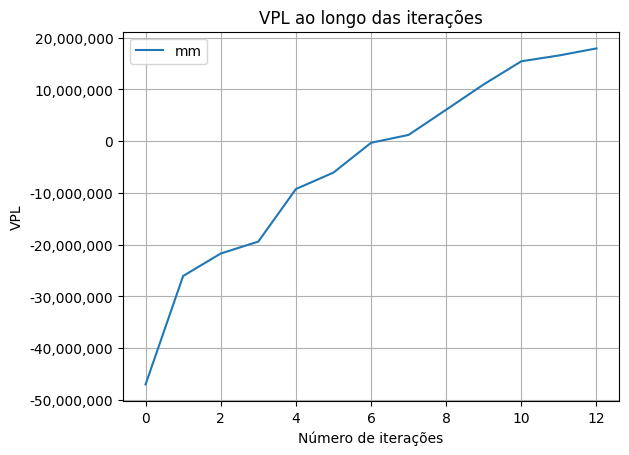

In [14]:
vpl_busca_local, sol_busca_local = busca_local(df_2, solucoes_alpha[2], 5, seed=11, metodo='mm')
print('Melhor melhor\nVPL: ', vpl_busca_local)
# vpl_busca_local, sol_busca_local = busca_local(df_2, solucoes_alpha[2], 30, seed=11, metodo='pm')
# print('Primeiro melhor\nVPL: ', vpl_busca_local)

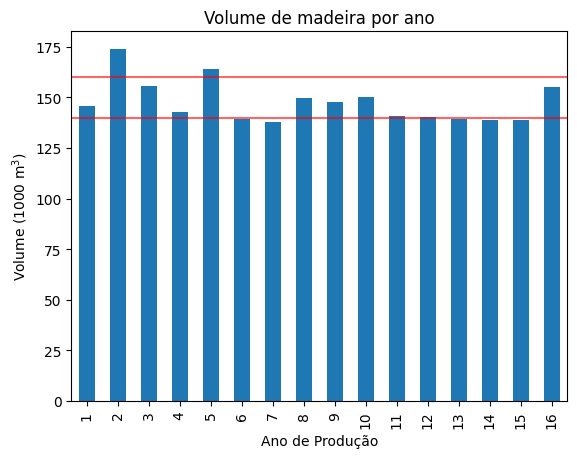

In [15]:
plota_volume(df_2, sol_busca_local)

---

# Gerar vizinhança 2

3 casos:

1. Dados o ano que mais acima da produção máxima, escolher dentro os talhões que podem fazer colheita nesse ano, escolher uma prescrição do melhor vizinho

2. Dados o ano que mais abaixo da produção mínima, escolher dentro os talhões que podem fazer colheita nesse ano, uma prescrição do melhor vizinho

3. Dados o ano dentro do limite e mais próximo da produção máxima, escolher dentro os talhões que podem fazer colheita nesse ano, escolher uma prescrição do melhor vizinho

Tempo máximo atingido
12  trocas para melhor vizinho
4  trocas para nova solução
Melhor melhor
VPL:  16577475


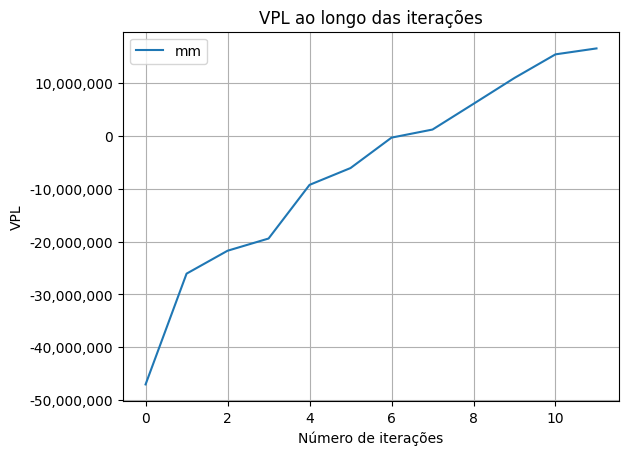

In [16]:
vpl_busca_local, sol_busca_local = busca_local(df_2, solucoes_alpha[2], 5, seed=11, metodo='mm', vizinhanca='localizada')
print('Melhor melhor\nVPL: ', vpl_busca_local)
# vpl_busca_local, sol_busca_local = busca_local(df_2, solucoes_alpha[2], 30, seed=11, metodo='pm', vizinhanca='localizada')
# print('Primeiro melhor\nVPL: ', vpl_busca_local)

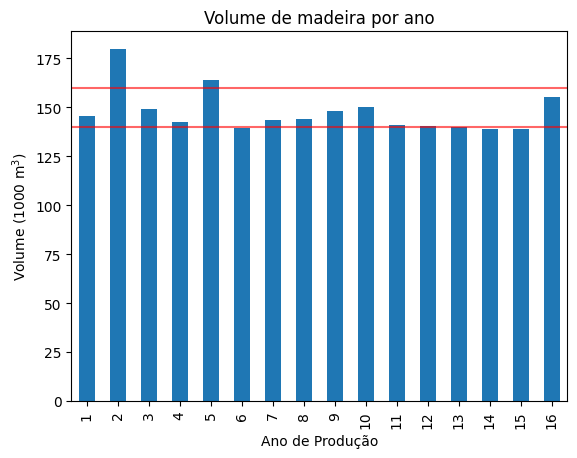

In [17]:
plota_volume(df_2, sol_busca_local)

---

# Gera vizinhanças 3

120 vizinhos compostos de uma troca sistematica de todos talhões por uma prescrição aleatória

Tempo máximo atingido
138  trocas para melhor vizinho
2276  trocas para nova solução
Melhor melhor
VPL:  30556244.0
Tempo máximo atingido
190  trocas para melhor vizinho
2345  trocas para nova solução
Melhor melhor
VPL:  30680128.0


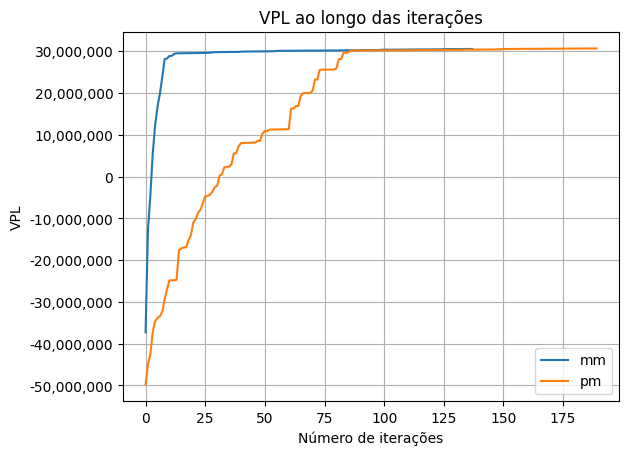

In [138]:
vpl_busca_local, sol_busca_local = busca_local(df_2, solucoes_alpha[2], 3600, seed=11, metodo='mm', vizinhanca='sistematica')
print('Melhor melhor\nVPL: ', vpl_busca_local)
vpl_busca_local, sol_busca_local = busca_local(df_2, solucoes_alpha[2], 3600, seed=11, metodo='pm', vizinhanca='sistematica')
print('Melhor melhor\nVPL: ', vpl_busca_local)

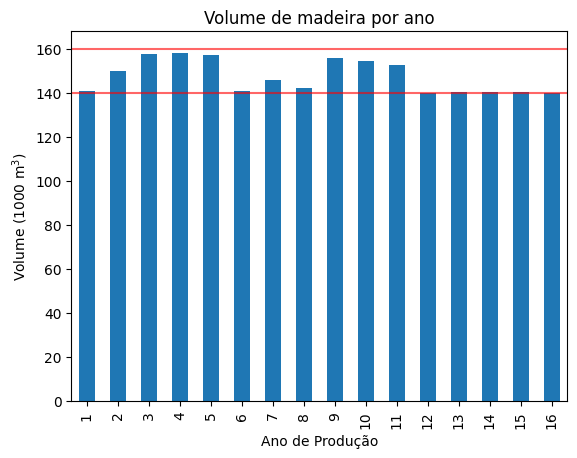

In [139]:
plota_volume(df_2, sol_busca_local)